In [2]:
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import scipy
import bbknn
import harmonypy as hm
from scipy.io import mmread

/slurm/home/yrd/liaolab/caohaoxue/anaconda3/envs/my_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Anndata to matrix

In [3]:
Z2CS7 = sc.read_h5ad('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/data_standard/Zygote_to_CS7.h5ad')
CS7 = sc.read_h5ad('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/data_standard/CS7.h5ad')
CS9 = sc.read_h5ad('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/data_standard/CS9.h5ad')
CS10 = sc.read_h5ad('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/data_standard/CS10.h5ad')
CS11 = sc.read_h5ad('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/data_standard/CS11.h5ad')
CS12_16 = sc.read_h5ad('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/data_standard/CS12_to_CS16.h5ad')

In [8]:
print("Z2CS7 ",Z2CS7.X.sum(axis = 1),
      "CS7 ",CS7.X.sum(axis = 1),
      "CS9 ",CS9.X.sum(axis = 1),
      "CS10 ",CS10.X.sum(axis = 1),
      "CS11 ",CS11.X.sum(axis = 1),
      "CS12 ",CS12_16.X.sum(axis = 1))

Z2CS7  [4082.6748 4121.707  4336.3438 ... 2826.0564 3987.292  4047.2817] CS7  [3758.31794021 4274.12415777 4054.03767242 ... 2982.75165242 4059.02975134
 4125.48255333] CS9  [2111.5781 1301.4359 4299.1523 ... 1908.2448 4266.2554 3133.8875] CS10  [3210.5    2927.426  3147.4294 ... 2467.341  3145.186  3132.8608] CS11  [[2045.69773818]
 [1979.42957792]
 [1453.33211476]
 ...
 [2455.05321505]
 [ 977.92268426]
 [1196.80710124]] CS12  [[2966.92131992]
 [2882.42488264]
 [3106.21975221]
 ...
 [1361.38608036]
 [2363.77271873]
 [2646.02393157]]


In [35]:
Z2CS7.var.columns = ["features"]
Z2CS7.var.index = Z2CS7.var.features
Z2CS7.var

,features
features,
AL627309.1,AL627309.1
AL627309.3,AL627309.3
AC114498.1,AC114498.1
AL669831.5,AL669831.5
FAM87B,FAM87B
...,...
U62317.5,U62317.5
FP475955.3,FP475955.3
LINC01436,LINC01436


In [9]:
CS10.var.columns = ["features"]
CS10.var.index = CS10.var.features
CS10.var

CS10.obs['time'] = "CS10"

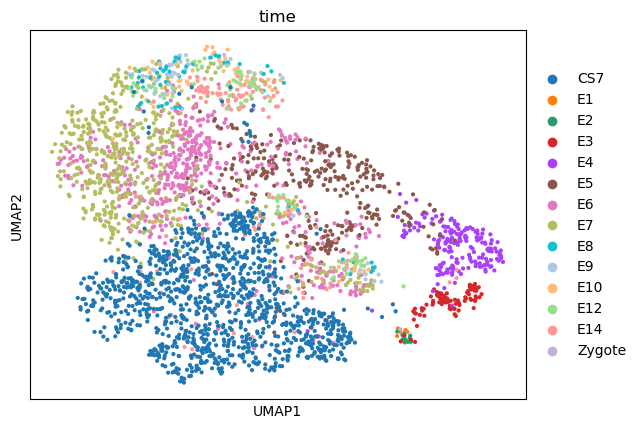

In [13]:
sc.pl.umap(Z2CS7,color = 'time')

In [42]:
E14 = Z2CS7[Z2CS7.obs.time == 'E14']
E12 = Z2CS7[Z2CS7.obs.time == 'E12']
E10 = Z2CS7[Z2CS7.obs.time == 'E10']
E9 = Z2CS7[Z2CS7.obs.time == 'E9']
E8 = Z2CS7[Z2CS7.obs.time == 'E8']
E7 = Z2CS7[Z2CS7.obs.time == 'E7']

In [10]:
CS12 = CS12_16[CS12_16.obs.time == 'CS12']

In [76]:
CS11

AnnData object with n_obs × n_vars = 41833 × 41374
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_type', 'time', 'merge_type'
    var: 'features'
    uns: 'cell_type_colors', 'log1p', 'merge_type_colors', 'orig.ident_colors'
    obsm: 'X_umap'
    layers: 'counts'

In [16]:
CS12

View of AnnData object with n_obs × n_vars = 21974 × 32345
    obs: 'cell_type', 'embryo', 'time'
    var: 'features'
    uns: 'log1p'
    layers: 'counts'

In [3]:
CS11 = CS11[CS11.obs['nCount_RNA'] > 500, :]
CS11

View of AnnData object with n_obs × n_vars = 40078 × 41374
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_type', 'time', 'merge_type'
    var: 'features'
    uns: 'cell_type_colors', 'log1p', 'merge_type_colors', 'orig.ident_colors'
    obsm: 'X_umap'
    layers: 'counts'

In [4]:
np.random.seed(0)
n_cells = CS11.n_obs
keep_indices = np.random.choice(n_cells, size=int(n_cells * 0.4), replace=False)
CS11_sampled = CS11[keep_indices, :].copy()

In [5]:
CS11_sampled

AnnData object with n_obs × n_vars = 16031 × 41374
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_type', 'time', 'merge_type'
    var: 'features'
    uns: 'cell_type_colors', 'log1p', 'merge_type_colors', 'orig.ident_colors'
    obsm: 'X_umap'
    layers: 'counts'

In [11]:
adata = sc.concat([CS10,CS12],
                 join = 'outer',
                 fill_value=0,
                 index_unique='-')
sc.pp.filter_genes(adata, min_cells = 3)
sc.pp.highly_variable_genes(adata, n_top_genes = 8000)
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 34297 × 8000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_type', 'clusters', 'merge_type', 'time', 'developmental system', 'embryo'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'X_UMAP', 'X_pca', 'X_umap'
    layers: 'counts'

In [12]:
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,cell_type,clusters,merge_type,time,developmental system,embryo
AAACCTGAGAATGTTG-1-0,0.0,14533.0,3468.0,Lateral plate Mesoderm 1,0.0,Mesoderm,CS10,NaN,NaN
AAACCTGAGCCAGAAC-1-0,0.0,22344.0,3874.0,Neural tbue 1,6.0,Ectoderm,CS10,NaN,NaN
AAACCTGAGGCAGTCA-1-0,0.0,31685.0,4640.0,Intermediate Mesoderm,0.0,Mesoderm,CS10,NaN,NaN
AAACCTGAGGGATGGG-1-0,0.0,21207.0,4248.0,Intermediate Mesoderm,0.0,Mesoderm,CS10,NaN,NaN
AAACCTGAGTGACATA-1-0,0.0,16551.0,3737.0,Somite,1.0,Mesoderm,CS10,NaN,NaN
...,...,...,...,...,...,...,...,...,...
TTGCCGTAGTGCGATG-1-1,NaN,NaN,NaN,erythroid,NaN,Mesoderm,CS12,blood,emb1
TTGCGTCAGAATTCCC-1-1,NaN,NaN,NaN,erythroid,NaN,Mesoderm,CS12,blood,emb1
TTTGGTTAGTCGCCGT-1-1,NaN,NaN,NaN,erythroid,NaN,Mesoderm,CS12,blood,emb1
CCTAGCTGTGTGCGTC-1-1,NaN,NaN,NaN,PGC,NaN,Ectoderm,CS12,PGC,emb1


In [13]:
np.random.seed(0)
n_cells = adata.n_obs
keep_indices = np.random.choice(n_cells, size=int(n_cells * 0.5), replace=False)
adata_sampled = adata[keep_indices, :].copy()
adata_sampled

AnnData object with n_obs × n_vars = 17148 × 8000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'cell_type', 'clusters', 'merge_type', 'time', 'developmental system', 'embryo'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'X_UMAP', 'X_pca', 'X_umap'
    layers: 'counts'

In [14]:
adata = adata_sampled

In [15]:
counts = adata.layers['counts'].T
gene = adata.var
cell = adata.obs

In [17]:
counts = scipy.sparse.csr_matrix(counts)

In [19]:
scipy.io.mmwrite('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/benchmark/source_matrix/CS10_CS12_2CS11_counts.mtx', counts)
pd.DataFrame(gene).to_csv('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/benchmark/source_matrix/CS10_CS12_2CS11_gene.csv')
pd.DataFrame(cell).to_csv('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/benchmark/source_matrix/CS10_CS12_2CS11_cell.csv')

# Mtrices to anndata

In [62]:
count_matrix = mmread('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/benchmark/simulated_matrix/counts.mtx').T.toarray()
gene_ids = pd.read_csv('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/benchmark/simulated_matrix/gene.csv')
cell_ids = pd.read_csv('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/benchmark/simulated_matrix/cell.csv')

In [35]:
count_matrix = pd.read_csv('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/benchmark/simulated_matrix/counts.csv', index_col = 0).T
gene_ids = pd.read_csv('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/benchmark/simulated_matrix/gene.csv')
cell_ids = pd.read_csv('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/benchmark/simulated_matrix/cell.csv')

## Splatter

In [66]:
adata.obs.drop(columns=['Unnamed: 0'], inplace=True)
adata.obs.index = adata.obs.Cell
adata.obs['time'] = "E14-splatter-simple"
adata.obs

,Cell,time
Cell,,
Cell1,Cell1,E14-splatter-simple
Cell2,Cell2,E14-splatter-simple
Cell3,Cell3,E14-splatter-simple
Cell4,Cell4,E14-splatter-simple
Cell5,Cell5,E14-splatter-simple
...,...,...
Cell1276,Cell1276,E14-splatter-simple
Cell1277,Cell1277,E14-splatter-simple
Cell1278,Cell1278,E14-splatter-simple


In [67]:
adata.var.drop(columns=['Unnamed: 0'], inplace=True)
adata.var = adata.var.rename(columns = {'value':'features'})
adata.var.index = adata.var.features
adata.var

,features
features,
A1BG.AS1,A1BG.AS1
A1CF,A1CF
A2M,A2M
A2ML1,A2ML1
AACS,AACS
...,...
ZXDC,ZXDC
ZYG11A,ZYG11A
ZYG11B,ZYG11B


## scDesign3

In [41]:
adata.obs = adata.obs.rename(columns = {'Unnamed: 0':'barcode'})
adata.obs.index = adata.obs.barcode
adata.obs['time'] = "E14-scDesign3"
adata.obs

,barcode,merge_type,pseudotime,time
barcode,,,,
SS.sc7785290,SS.sc7785290,Mesoderm,31.221305,E14-scDesign3
SS.sc7786612,SS.sc7786612,Endoderm,9.080529,E14-scDesign3
SS.sc7786605,SS.sc7786605,Mesoderm,12.042689,E14-scDesign3
SS.sc7785737,SS.sc7785737,Primitive Streak,5.356720,E14-scDesign3
SS.sc7785398,SS.sc7785398,YolkSac,16.457844,E14-scDesign3
...,...,...,...,...
D12A4B9,D12A4B9,Trophoblast,7.680723,E14-scDesign3
D12A3B10,D12A3B10,Trophoblast,7.683735,E14-scDesign3
D12A3B11,D12A3B11,Trophoblast,7.678798,E14-scDesign3


In [42]:
adata.var['features'] = adata.var.index
adata.var.index = adata.var.features
adata.var

,features
features,
A1BG.AS1,A1BG.AS1
A1CF,A1CF
A2M,A2M
A2ML1,A2ML1
AACS,AACS
...,...
ZXDC,ZXDC
ZYG11A,ZYG11A
ZYG11B,ZYG11B


# Export

In [43]:
adata.write_h5ad('/slurm/home/yrd/liaolab/caohaoxue/embryo_work/benchmark/simulated_matrix/h5ad_format/E14f_scDesign3.h5ad')